# Machine Learning in Economics

**Author**
> - [Paul Schrimpf *UBC*](https://economics.ubc.ca/faculty-and-staff/paul-schrimpf/)

**Prerequisites**

- {doc}`Regression <regression>`

**Outcomes**

- Understand how economists use machine learning in
  academic research


```{literalinclude} ../_static/colab_full.raw
```

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd


%matplotlib inline
#plt.style.use('tableau-colorblind10')
#plt.style.use('Solarize_Light2')
plt.style.use('bmh')

## Introduction

Machine learning is increasingly being utilized in economic
research. Here, we discuss three main ways that economists are
currently using machine learning methods.

## Prediction Policy

Most empirical economic research focuses on questions of
causality. However, machine learning methods can actually be used
in economic research or policy making when the goal is prediction.

{cite}`ml-kleinberg2015` is a short paper which makes this point.

> Consider two toy examples. One policymaker facing a drought must
> decide whether to invest in a rain dance to increase the chance
> of rain.  Another seeing clouds must decide whether to take an
> umbrella to work to avoid getting wet on the way home. Both
> decisions could benefit from an empirical study of rain. But each
> has differ-ent requirements of the estimator. One requires
> causality: Do rain dances cause rain? The other does not, needing
> only prediction: Is the chance of rain high enough to merit an
> umbrella?  We often focus on rain dance–like policy problems. But
> there are also many umbrella-like policy problems.  Not only are
> these prediction problems neglected, machine learning can help
> us solve them more effectively.  {cite}`ml-kleinberg2015`.

One of their examples is the allocation of joint replacements for
osteoarthritis in elderly patients. Joint replacements are costly,
both monetarily and in terms of potentially painful recovery from
surgery. Joint replacements may not be worthwhile for patients who do
not live long enough afterward to enjoy the
benefits. {cite}`ml-kleinberg2015` uses machine learning methods to
predict mortality and argues that avoiding joint replacements
for people with the highest predicted mortality risk could lead to
sizable benefits.

Other situations where improved prediction could improve economic
policy include:

- Targeting safety or health inspections.
- Predicting highest risk youth for targeting interventions.
- Improved risk scoring in insurance markets to reduce adverse
  selection.
- Improved credit scoring to better allocate credit.
- Predicting the risk someone accused of a crime does not show up for
  trial to help decide whether to offer bail {cite}`ml-kleinberg2017`.

We investigated one such prediction policy problem in
{doc}`recidivism <recidivism>`.

## Estimation of Nuisance Functions

Most empirical economic studies are interested in a single low
dimensional parameter, but determining that parameter may require estimating additional
"nuisance" parameters to estimate this coefficient consistently and avoid omitted variables
bias. However, the choice of which other variables to include and
their functional forms is often somewhat arbitrary.
One promising idea is to use machine learning methods to let the data
decide what control variables to include and how. Care must be
taken when doing so, though, because machine learning's flexibility and complexity
-- what make it so good at prediction -- also pose
challenges for inference.

### Partially Linear Regression

To be more concrete, consider a regression model.  We have some
regressor of interest, $d$, and we want to estimate the effect of $d$
on $y$. We have a rich enough set of controls $x$ that we are willing to
believe that $E[\epsilon|d,x] = 0$ . $d_i$ and $y_i$ are scalars, while
$x_i$ is a vector. We are not interested in $x$ per se, but we need to
include it to avoid omitted variable bias. Suppose the true model
generating the data is:

$$
y = \theta d + f(x) + \epsilon
$$

where $f(x)$ is some unknown function. This is called a
partially linear model: linear in $d$, but not in
$x$ .

A typical applied econometric approach for this model would
be to choose some transform of $x$, say $X = T(x)$, where $X$
could be some subset of $x$ , perhaps along with interactions, powers, and
so on. Then, we estimate a linear regression,

$$
y = \theta d + X'\beta + e
$$

and then perhaps also report results for a handful of different
choices of $T(x)$ .

Some downsides to the typical applied econometric practice
include:

- The choice of $T$ is arbitrary, which opens the door to specification
  searching and p-hacking.
- If $x$ is high dimensional and $X$ is low dimensional, a poor
  choice will lead to omitted variable bias. Even if $x$ is low
  dimensional,  omitted variable bias occurs if $f(x)$ is poorly approximated by $X'\beta$.

In some sense, machine learning can be thought of as a way to
choose $T$ in an automated and data-driven way. Choosing which machine learning method
to use and tuning parameters specifically for that method are still potentially arbitrary
decisions, but these decisions may have less impact.

Economic researchers typically don't just want an estimate of
$\theta$, $\hat{\theta}$. Instead, they want to know that
$\hat{\theta}$ has good statistical properties (it should at
least be consistent), and they want some way to quantify how uncertain is
$\hat{\theta}$ (i.e. they want a standard error). The complexity
of machine learning methods makes their statistical properties
difficult to understand. If we want $\hat{\theta}$ to have
known and good statistical properties, we must make sure we use machine
learning methods correctly.  A procedure to estimate
$\theta$ in the partially linear model is as follows:

1. Predict $y$ and $d$ from $x$ using any machine
   learning method with "cross-fitting".
    - Partition the data in $k$ subsets.
    - For the $j$ th subset, train models to predict $y$ and $d$
      using the other $k-1$ subsets. Denote the predictions from
      these models as $p^y_{-j}(x)$ and  $p^d_{-j}(x)$.
    - For $y_i$ in the $j$ -th subset use the other
      $k-1$ subsets to predict $\hat{y}_i = p^y_{-j(i)}(x_i)$
1. Partial out $x$ : let $\tilde{y}_i = y_i - \hat{y}_i$
   and $\tilde{d}_i = d_i - \hat{d}_i$.
1. Regress $\tilde{y}_i$ on $\tilde{d}_i$, let
   $\hat{\theta}$ be the estimated coefficient for
   $\tilde{d}_i$ . $\hat{\theta}$ is consistent,
   asymptotically normal, and has the usual standard error (i.e. the
   standard error given by statsmodels is correct).

Some remarks:

- This procedure gives a $\hat{\theta}$ that has the same
  asymptotic distribution as what we would get if we knew the true
  $f(x)$ . In statistics, we call this an oracle property,
  because it is as if an all knowing oracle told us $f(x)$.
- This procedure requires some technical conditions on the data-generating
  process and machine learning estimator, but we will not worry about them here. See
  {cite}`ml-chernozhukov2018` for details.

Here is code implementing the above idea.

In [2]:
from sklearn.model_selection import cross_val_predict
from sklearn import linear_model
import statsmodels as sm

def partial_linear(y, d, X, yestimator, destimator, folds=3):
    """Estimate the partially linear model y = d*C + f(x) + e

    Parameters
    ----------
    y : array_like
        vector of outcomes
    d : array_like
        vector or matrix of regressors of interest
    X : array_like
        matrix of controls
    mlestimate : Estimator object for partialling out X. Must have ‘fit’
        and ‘predict’ methods.
    folds : int
        Number of folds for cross-fitting

    Returns
    -------
    ols : statsmodels regression results containing estimate of coefficient on d.
    yhat : cross-fitted predictions of y
    dhat : cross-fitted predictions of d
    """

    # we want predicted probabilities if y or d is discrete
    ymethod = "predict" if False==getattr(yestimator, "predict_proba",False) else "predict_proba"
    dmethod = "predict" if False==getattr(destimator, "predict_proba",False) else "predict_proba"
    # get the predictions
    yhat = cross_val_predict(yestimator,X,y,cv=folds,method=ymethod)
    dhat = cross_val_predict(destimator,X,d,cv=folds,method=dmethod)
    ey = np.array(y - yhat)
    ed = np.array(d - dhat)
    ols = sm.regression.linear_model.OLS(ey,ed).fit(cov_type='HC0')

    return(ols, yhat, dhat)

### Application: Gender Wage Gap

Okay, enough theory. Let's look at an application. Policy makers have
long been concerned with the gender wage gap. We will examine the
gender wage gap using data from the 2018 Current Population Survey (CPS) in
the US. In particular, we will use the version of the [CPS provided by
the NBER](https://www.nber.org/cps/).

In [3]:
import statsmodels.formula.api as smf
from statsmodels.iolib.summary2 import summary_col
# Download CPS data
cpsall = pd.read_stata("https://www.nber.org/morg/annual/morg18.dta")

# take subset of data just to reduce computation time
cps = cpsall.sample(30000, replace=False, random_state=0)
display(cps.head())
cps.describe()

,hhid,intmonth,hurespli,hrhtype,minsamp,hrlonglk,hrsample,hrhhid2,serial,hhnum,...,ym_file,ym,ch02,ch35,ch613,ch1417,ch05,ihigrdc,docc00,dind02
103153,150909100105603,May,1.0,Civilian male primary individual,MIS 4,MIS 2-4 Or MIS 6-8 (link To,0801,08011,1,1,...,700,697,0,0,0,0,0,NaN,Business and financial operations occupations,Professional and Technical services
76648,505760912076673,March,1.0,Husband/wife primary fam (neither in Armed For...,MIS 4,MIS 2-4 Or MIS 6-8 (link To,0811,08111,1,1,...,698,695,0,0,0,0,0,12.0,NaN,NaN
51433,481462012350753,February,1.0,Husband/wife primary fam (neither in Armed For...,MIS 4,MIS 2-4 Or MIS 6-8 (link To,0701,07011,1,1,...,697,694,0,0,0,0,0,NaN,Management occupations,Agriculture
75550,106518879410166,March,2.0,Husband/wife primary fam (neither in Armed For...,MIS 8,MIS 2-4 Or MIS 6-8 (link To,0611,06111,1,1,...,698,683,0,0,0,0,0,11.0,NaN,NaN
284643,466023401171104,December,1.0,Husband/wife primary fam (neither in Armed For...,MIS 4,MIS 2-4 Or MIS 6-8 (link To,0901,09011,1,1,...,707,704,0,1,1,0,1,13.0,Management occupations,Membership associations and organizations


,hurespli,hhnum,cbsafips,county,centcity,smsastat,icntcity,smsa04,relref95,age,...,recnum,year,ym_file,ym,ch02,ch35,ch613,ch1417,ch05,ihigrdc
count,29997.000000,30000.000000,30000.000000,30000.000000,24701.000000,29689.000000,3845.000000,30000.000000,30000.000000,30000.000000,...,30000.00000,30000.0,30000.000000,30000.000000,30000.00000,30000.000000,30000.000000,30000.000000,30000.000000,21463.000000
mean,1.314898,1.052733,22812.328667,25.752033,1.926157,1.188150,1.377373,3.687667,3.200333,47.856967,...,217052.62500,2018.0,701.467433,692.357833,0.06040,0.065333,0.143033,0.086467,0.105033,12.355938
std,0.683163,0.245943,16494.302775,62.862911,0.721596,0.390839,0.946464,2.592477,3.291772,18.757968,...,125652.34375,0.0,3.467921,6.970577,0.23823,0.247117,0.350113,0.281057,0.306601,2.478719
min,0.000000,1.000000,0.000000,0.000000,1.000000,1.000000,1.000000,0.000000,1.000000,16.000000,...,19.00000,2018.0,696.000000,681.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,1.000000,1.000000,0.000000,0.000000,1.000000,1.000000,1.000000,0.000000,1.000000,32.000000,...,108185.25000,2018.0,698.000000,686.000000,0.00000,0.000000,0.000000,0.000000,0.000000,12.000000
50%,1.000000,1.000000,25420.000000,0.000000,2.000000,1.000000,1.000000,4.000000,2.000000,48.000000,...,217388.50000,2018.0,701.000000,692.000000,0.00000,0.000000,0.000000,0.000000,0.000000,12.000000
75%,1.000000,1.000000,37900.000000,29.000000,2.000000,1.000000,1.000000,6.000000,3.000000,63.000000,...,325915.00000,2018.0,704.000000,698.000000,0.00000,0.000000,0.000000,0.000000,0.000000,14.000000
max,11.000000,8.000000,49740.000000,810.000000,3.000000,2.000000,7.000000,7.000000,18.000000,85.000000,...,434279.00000,2018.0,707.000000,704.000000,1.00000,1.000000,1.000000,1.000000,1.000000,18.000000


The variable "earnwke" records weekly earnings. Two
variables detail the hours of work. "uhours" is usual hours worked per
week, and "hourslw" is hours worked last week. We will try using each
measure of hours to construct the wage.  Let's estimate the
unconditional gender earnings and wage gaps.

In [4]:
cps["female"] = (cps.sex==2)
cps["log_earn"] = np.log(cps.earnwke)
cps["log_earn"][np.isinf(cps.log_earn)] = np.nan
cps["log_uhours"] = np.log(cps.uhourse)
cps["log_uhours"][np.isinf(cps.log_uhours)] = np.nan
cps["log_hourslw"] = np.log(cps.hourslw)
cps["log_hourslw"][np.isinf(cps.log_hourslw)] = np.nan
cps["log_wageu"] = cps.log_earn - cps.log_uhours
cps["log_wagelw"] = cps.log_earn - cps.log_hourslw


lm = list()
lm.append(smf.ols(formula="log_earn ~ female", data=cps,
                  missing="drop").fit(cov_type='HC0'))
lm.append( smf.ols(formula="log_wageu ~ female", data=cps,
                   missing="drop").fit(cov_type='HC0'))
lm.append(smf.ols(formula="log_wagelw ~ female", data=cps,
                  missing="drop").fit(cov_type='HC0'))
lm.append(smf.ols(formula="log_earn ~ female + log_hourslw + log_uhours", data=cps,
                  missing="drop").fit(cov_type='HC0'))

/usr/share/miniconda3/envs/lecture-datascience/lib/python3.8/site-packages/pandas/core/arraylike.py:358: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)
<ipython-input-4-ea5a68680746>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  cps["log_earn"][np.isinf(cps.log_earn)] = np.nan
/usr/share/miniconda3/envs/lecture-datascience/lib/python3.8/site-packages/pandas/core/arraylike.py:358: RuntimeWarning: invalid value encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)
<ipython-input-4-ea5a68680746>:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  cp

In [5]:
summary_col(lm, stars=True)

,log_earn I,log_wageu I,log_wagelw I,log_earn II
Intercept,6.7473***,3.0970***,3.1056***,1.8014***
,(0.0088),(0.0072),(0.0078),(0.0933)
R-squared,0.0338,0.0179,0.0149,0.4139
R-squared Adj.,0.0337,0.0179,0.0148,0.4137
female[T.True],-0.3004***,-0.1695***,-0.1707***,-0.1258***
,(0.0127),(0.0102),(0.0112),(0.0105)
log_hourslw,,,,0.0907***
,,,,(0.0285)
log_uhours,,,,1.2631***
,,,,(0.0431)


The unconditional gender gap in log earnings is about -0.3. Women earn
about 30% less than men. The unconditional gender wage gap is about
18%. The last column gives the gender earnings gap conditional on
hours. This could differ from the wage gap if, for example, full time
workers are paid higher wages than part-time. Some evidence
has suggested this, and the gender earnings gap conditional on hours is about
15%.

#### Equal Pay for Equal Work?

A common slogan is equal pay for equal work. One way to interpret this
is that for employees with similar worker and job characteristics, no gender wage gap should exist.

Eliminating this wage gap across similar worker and job characteristics is one necessary
(though insufficient) condition for equality. Some of the differences (like hours in the 4th column of the above table)
might actually be a result of societal norms and/or
discrimination, so we don't want to overgeneralize.

Nonetheless, let's examine whether there is a gender wage gap
conditional on all worker and job characteristics. We want to ensure
that we control for those characteristics as flexibly as
possible, so we will use the partially linear model described above.

In [6]:
from patsy import dmatrices
# Prepare data
fmla  = "log_earn + female ~ log_uhours + log_hourslw + age + I(age**2) + C(race) + C(cbsafips) + C(smsastat) + C(grade92) + C(unionmme) + C(unioncov) + C(ind02) + C(occ2012)"
yd, X = dmatrices(fmla,cps)
female = yd[:,1]
logearn = yd[:,2]

The choice of regularization parameter is somewhat
tricky. Cross-validation is a good way to choose the best
regularization parameter when our goal is prediction. However,
our goal here is not prediction. Instead, we want to get a well-behaved
estimate of the gender wage gap. To achieve this, we generally need a
smaller regularization parameter than what would minimize
MSE. The following code picks such a regularization parameter. Note
however, that the details of this code might not meet the technical
theoretical conditions needed for our ultimate estimate of the gender
wage gap to be consistent and asymptotically normal. The R package,
"HDM" {cite}`ml-hdm` , chooses the regularization parameter in way that
is known to be correct.

In [7]:
# select regularization parameter
alphas = np.exp(np.linspace(-2, -12, 25))
lassoy = linear_model.LassoCV(cv=6, alphas=alphas, max_iter=5000).fit(X,logearn)
lassod = linear_model.LassoCV(cv=6, alphas=alphas, max_iter=5000).fit(X,female)

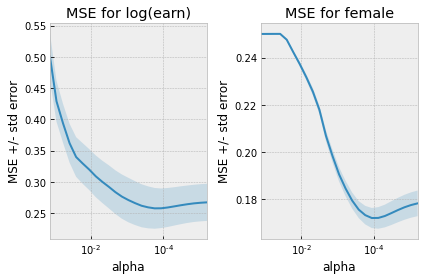

In [8]:
fig, ax = plt.subplots(1,2)

def plotlassocv(l, ax) :
    alphas = l.alphas_
    mse = l.mse_path_.mean(axis=1)
    std_error = l.mse_path_.std(axis=1)
    ax.plot(alphas,mse)
    ax.fill_between(alphas, mse + std_error, mse - std_error, alpha=0.2)

    ax.set_ylabel('MSE +/- std error')
    ax.set_xlabel('alpha')
    ax.set_xlim([alphas[0], alphas[-1]])
    ax.set_xscale("log")
    return(ax)

ax[0] = plotlassocv(lassoy,ax[0])
ax[0].set_title("MSE for log(earn)")
ax[1] = plotlassocv(lassod,ax[1])
ax[1].set_title("MSE for female")
fig.tight_layout()

# there are theoretical reasons to choose a smaller regularization
# than the one that minimizes cv. BUT THIS WAY OF CHOOSING IS ARBITRARY AND MIGHT BE WRONG
def pickalpha(lassocv) :
    imin = np.argmin(lassocv.mse_path_.mean(axis=1))
    msemin = lassocv.mse_path_.mean(axis=1)[imin]
    se = lassocv.mse_path_.std(axis=1)[imin]
    alpha= min([alpha for (alpha, mse) in zip(lassocv.alphas_, lassocv.mse_path_.mean(axis=1)) if mse<msemin+se])
    return(alpha)

alphay = pickalpha(lassoy)
alphad = pickalpha(lassod)

In [9]:
# show results
pl_lasso = partial_linear(logearn, female, X,
                          linear_model.Lasso(alpha=lassoy.alpha_),
                          linear_model.Lasso(alpha=lassod.alpha_))
pl_lasso[0].summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                 OLS Regression Results                                
=======================================================================================
Dep. Variable:                      y   R-squared (uncentered):                   0.009
Model:                            OLS   Adj. R-squared (uncentered):              0.009
Method:                 Least Squares   F-statistic:                              107.2
Date:                Mon, 07 Jun 2021   Prob (F-statistic):                    4.91e-25
Time:                        01:08:28   Log-Likelihood:                         -9718.3
No. Observations:               13052   AIC:                                  1.944e+04
Df Residuals:                   13051   BIC:                                  1.945e+04
Df Model:                           1                                                  
Covariance Type:                  HC0                                                  
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
x1            -0.1160      0.011    -10.356      0.000      -0.138      -0.094
==============================================================================
Omnibus:                     6939.182   Durbin-Watson:                   1.959
Prob(Omnibus):                  0.000   Jarque-Bera (JB):           410073.398
Skew:                          -1.777   Prob(JB):                         0.00
Kurtosis:                      30.229   Cond. No.                         1.00
==============================================================================

Notes:
[1] R² is computed without centering (uncentered) since the model does not contain a constant.
[2] Standard Errors are heteroscedasticity robust (HC0)
"""

/usr/share/miniconda3/envs/lecture-datascience/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(
/usr/share/miniconda3/envs/lecture-datascience/lib/python3.8/site-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


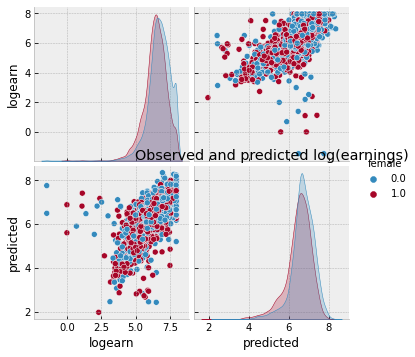

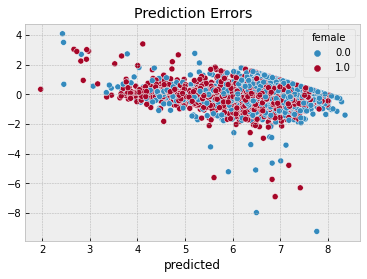

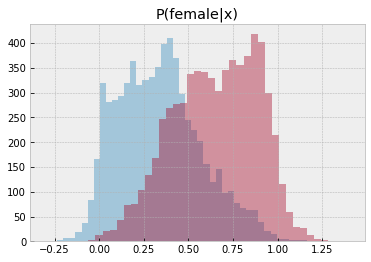

In [10]:
import seaborn as sns
# Visualize predictions
def plotpredictions(pl) :
    df = pd.DataFrame({"logearn":logearn,
                       "predicted":pl[1],
                       "female":female,
                       "P(female|x)":pl[2]})
    sns.pairplot(df, vars=["logearn","predicted"], hue="female")
    plt.title("Observed and predicted log(earnings)")

    plt.figure()
    sns.scatterplot(df.predicted, df.logearn-df.predicted, hue=df.female)
    plt.title("Prediction Errors")

    plt.figure()
    sns.distplot(pl[2][female==0], hist = True, kde = False,
                 kde_kws = {'shade': True, 'linewidth': 3},
                 label = "Male")
    sns.distplot(pl[2][female==1], hist = True, kde = False,
                 kde_kws = {'shade': True, 'linewidth': 3},
                 label = "Female")
    plt.title('P(female|x)')
plotpredictions(pl_lasso)

We see that the gender earnings gap is
12.4%, conditional on hours, age, race, location, education,
union membership, industry, and occupation.
Compared to the gap conditional on only hours, differences in other observable characteristics in the CPS seem unable explain much of the gender earnings gap.

We can repeat the same procedure with another machine learning method
in place of lasso. Let's try it with neural networks.

In [11]:
from sklearn import neural_network
from sklearn import preprocessing, pipeline, model_selection

nnp = pipeline.Pipeline(steps=[
    ("scaling", preprocessing.StandardScaler()),
    ("nn", neural_network.MLPRegressor((50,), activation="logistic",
                                       verbose=False, solver="adam",
                                       max_iter=400, early_stopping=True,
                                       validation_fraction=0.15))
])

nndcv = model_selection.GridSearchCV(estimator=nnp, scoring= 'neg_mean_squared_error', cv=4,
                                     param_grid = {'nn__alpha': np.exp(np.linspace(-5,5, 10))},
                                     return_train_score=True, verbose=True, refit=False,
                                     ).fit(X,female)

Fitting 4 folds for each of 10 candidates, totalling 40 fits


In [12]:
nnycv = model_selection.GridSearchCV(estimator=nnp, scoring= 'neg_mean_squared_error', cv=4,
                                     param_grid = {'nn__alpha': np.exp(np.linspace(-5,5, 10))},
                                     return_train_score=True, verbose=True, refit=False,
                                     ).fit(X,logearn)

Fitting 4 folds for each of 10 candidates, totalling 40 fits


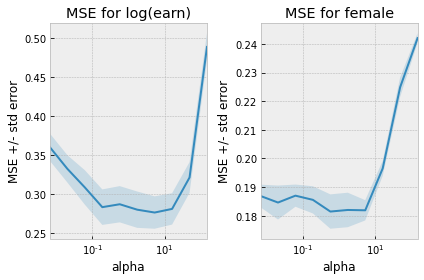

In [13]:
fig, ax = plt.subplots(1,2)

def plotgridcv(g, ax) :
    alphas = g.cv_results_["param_nn__alpha"].data.astype(float)
    mse = -g.cv_results_["mean_test_score"]
    std_error = g.cv_results_["std_test_score"]
    ax.plot(alphas,mse)
    ax.fill_between(alphas, mse+std_error, mse-std_error, alpha=0.2)

    ax.set_ylabel('MSE +/- std error')
    ax.set_xlabel('alpha')
    ax.set_xlim([alphas[0], alphas[-1]])
    ax.set_xscale("log")
    return(ax)

ax[0] = plotgridcv(nnycv,ax[0])
ax[0].set_title("MSE for log(earn)")
ax[1] = plotgridcv(nndcv,ax[1])
ax[1].set_title("MSE for female")
fig.tight_layout()

# there are theoretical reasons to choose a smaller regularization
# than the one that minimizes cv. BUT THIS WAY OF CHOOSING IS ARBITRARY AND MAYBE WRONG
def pickalphagridcv(g) :
    alphas = g.cv_results_["param_nn__alpha"].data
    mses = g.cv_results_["mean_test_score"]
    imin = np.argmin(mses)
    msemin = mses[imin]
    se = g.cv_results_["std_test_score"][imin]
    alpha= min([alpha for (alpha, mse) in zip(alphas, mses) if mse<msemin+se])
    return(alpha)

alphaynn = pickalphagridcv(nnycv)
alphadnn = pickalphagridcv(nndcv)

In [14]:
# show results
nny = nnp
nny.set_params(nn__alpha = alphaynn)
nnd = nnp
nnd.set_params(nn__alpha = alphadnn)
pl_nn = partial_linear(logearn, female, X,
                       nny, nnd)
pl_nn[0].summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                 OLS Regression Results                                
=======================================================================================
Dep. Variable:                      y   R-squared (uncentered):                   0.018
Model:                            OLS   Adj. R-squared (uncentered):              0.018
Method:                 Least Squares   F-statistic:                              239.6
Date:                Mon, 07 Jun 2021   Prob (F-statistic):                    1.45e-53
Time:                        01:14:42   Log-Likelihood:                         -13659.
No. Observations:               13052   AIC:                                  2.732e+04
Df Residuals:                   13051   BIC:                                  2.733e+04
Df Model:                           1                                                  
Covariance Type:                  HC0                                                  
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
x1            -0.1902      0.012    -15.479      0.000      -0.214      -0.166
==============================================================================
Omnibus:                     4146.931   Durbin-Watson:                   1.724
Prob(Omnibus):                  0.000   Jarque-Bera (JB):            46902.932
Skew:                          -1.198   Prob(JB):                         0.00
Kurtosis:                      11.973   Cond. No.                         1.00
==============================================================================

Notes:
[1] R² is computed without centering (uncentered) since the model does not contain a constant.
[2] Standard Errors are heteroscedasticity robust (HC0)
"""

/usr/share/miniconda3/envs/lecture-datascience/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(
/usr/share/miniconda3/envs/lecture-datascience/lib/python3.8/site-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


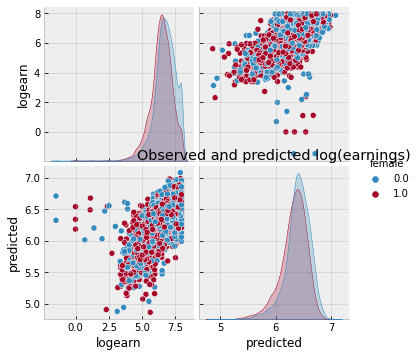

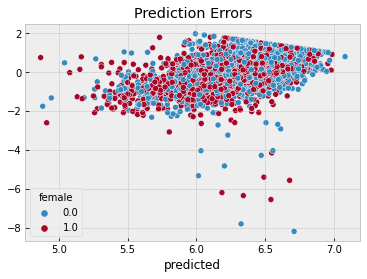

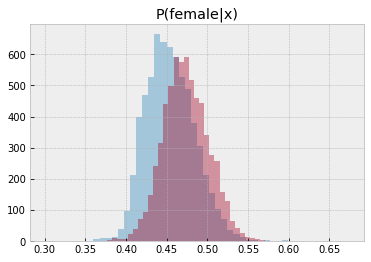

In [15]:
plotpredictions(pl_nn)

In [16]:
summary_col([pl_lasso[0], pl_nn[0]], model_names=["Lasso", "Neural Network"] ,stars=False)

,Lasso,Neural Network
x1,-0.1160,-0.1902
,(0.0112),(0.0123)
R-squared,0.0089,0.0181
R-squared Adj.,0.0088,0.0180


### Other Applications

Machine learning can be used to
estimate nuisance functions in many other situations. The partially linear model can easily be
extended to situations where the regressor of interest, $d$ , is
endogenous and instruments are available. See {cite}`ml-chernozhukov2018`
for details and additional examples.

## Heterogeneous Effects

A third area where economists are using machine learning is to
estimate heterogeneous effects.

Some important papers in this area are {cite}`ml-athey2016b` ,
{cite}`ml-wager2018` , and {cite}`ml-cddf2018` .

We will explore this is more depth in {doc}`heterogeneity <heterogeneity>`.

## References

```{bibliography} applications.bib
:keyprefix: ml-
:labelprefix: ml
:cited:
```